In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Cell 2: Load & clean columns
df = pd.read_csv(r"D:\Codes\pred_maintain\data\data.csv")

# Clean column names (strip spaces and non-breaking spaces)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace("\xa0", "", regex=True)
print("Columns:", df.columns.tolist())
df.head()


Columns: ['index', 'Lever position', 'Ship speed (v)', 'Gas Turbine (GT) shaft torque (GTT) [kN m]', 'GT rate of revolutions (GTn) [rpm]', 'Gas Generator rate of revolutions (GGn) [rpm]', 'Starboard Propeller Torque (Ts) [kN]', 'Port Propeller Torque (Tp) [kN]', 'Hight Pressure (HP) Turbine exit temperature (T48) [C]', 'GT Compressor inlet air temperature (T1) [C]', 'GT Compressor outlet air temperature (T2) [C]', 'HP Turbine exit pressure (P48) [bar]', 'GT Compressor inlet air pressure (P1) [bar]', 'GT Compressor outlet air pressure (P2) [bar]', 'GT exhaust gas pressure (Pexh) [bar]', 'Turbine Injecton Control (TIC) [%]', 'Fuel flow (mf) [kg/s]', 'GT Compressor decay state coefficient', 'GT Turbine decay state coefficient']


,index,Lever position,Ship speed (v),Gas Turbine (GT) shaft torque (GTT) [kN m],GT rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],Hight Pressure (HP) Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],GT exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient,GT Turbine decay state coefficient
0,0,1.138,3,289.964,1349.489,6677.380,7.584,7.584,464.006,288,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,1,2.088,6,6960.180,1376.166,6828.469,28.204,28.204,635.401,288,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,2,3.144,9,8379.229,1386.757,7111.811,60.358,60.358,606.002,288,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,3,4.161,12,14724.395,1547.465,7792.630,113.774,113.774,661.471,288,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,4,5.140,15,21636.432,1924.313,8494.777,175.306,175.306,731.494,288,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


In [3]:
# Cell 3: Check decay columns exist and inspect them
decay_cols_candidates = [c for c in df.columns if "decay" in c.lower()]
print("Detected decay-like columns:", decay_cols_candidates)
df[decay_cols_candidates].describe().T


Detected decay-like columns: ['GT Compressor decay state coefficient', 'GT Turbine decay state coefficient']


,count,mean,std,min,25%,50%,75%,max
GT Compressor decay state coefficient,11934.0,0.9750,0.01472,0.950,0.962,0.9750,0.988,1.0
GT Turbine decay state coefficient,11934.0,0.9875,0.00750,0.975,0.981,0.9875,0.994,1.0


In [4]:
# Cell 4: Create a combined health index from decay coefficients
# Use available decay columns; if two exist (compressor/turbine) we average them.
if len(decay_cols_candidates) == 0:
    raise ValueError("No decay columns found. Please provide GT decay state coefficients in the CSV.")

# Build health index (higher means healthier)
df["health_index_raw"] = df[decay_cols_candidates].mean(axis=1)

# If health is not in [0,1], scale it
h_min, h_max = df["health_index_raw"].min(), df["health_index_raw"].max()
print(f"Health raw min/max: {h_min:.4f} / {h_max:.4f}")

# Normalize to [0,1] (0 = worst, 1 = best)
df["health_index"] = (df["health_index_raw"] - h_min) / (h_max - h_min + 1e-12)
df[["health_index_raw", "health_index"]].head()


Health raw min/max: 0.9625 / 1.0000


,health_index_raw,health_index
0,0.9625,0.0
1,0.9625,0.0
2,0.9625,0.0
3,0.9625,0.0
4,0.9625,0.0


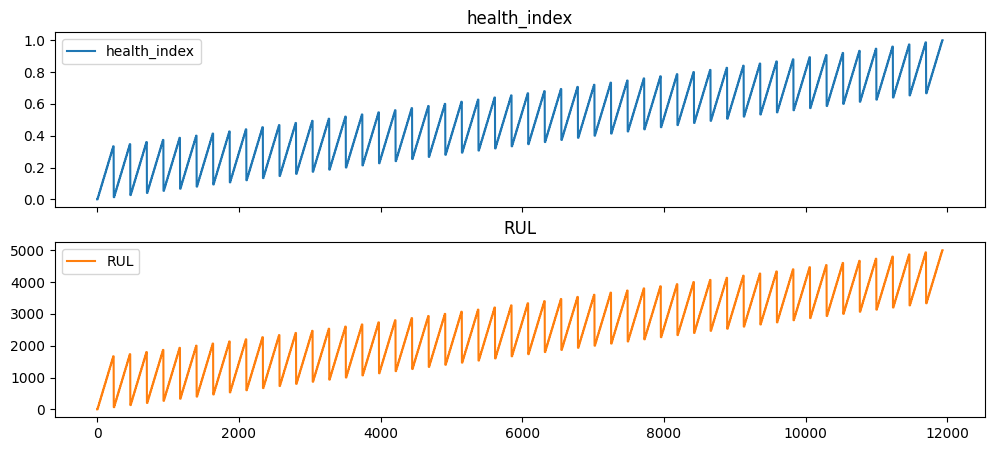

In [33]:
# Cell 5: Map health -> RUL (assumption-based)
# We assume health 1 -> MAX_RUL remaining life, health 0 -> 0 remaining life.
# Choose MAX_RUL according to domain knowledge. Default = 5000 (adjustable).
MAX_RUL = 5000


# RUL decreases as health decreases
df["RUL"] = (df["health_index"] * MAX_RUL).round().astype(float)

# Optionally, if you prefer RUL to be "distance to failure" starting from first timestep:
# df["RUL_from_start"] = MAX_RUL - df["RUL"]
df[["health_index", "RUL"]].plot(subplots=True, figsize=(12,5), title=["health_index", "RUL"])
plt.show()


In [6]:
# Cell 6: Select features for model input
# Choose sensor columns that matter. We'll automatically pick common sensors (speeds, temps, pressures, flows).
feature_keywords = ["T", "P", "mf", "GTn", "GGn", "GTT", "Torque", "speed", "v", "Lever", "TIC"]
# create a conservative feature list using substring matching (case-insensitive)
features = []
cols_lower = {c.lower(): c for c in df.columns}
for kw in feature_keywords:
    for col in df.columns:
        if kw.lower() in col.lower() and col not in decay_cols_candidates and "rul" not in col.lower() and "health" not in col.lower():
            features.append(col)
# Ensure features unique and not empty
features = list(dict.fromkeys(features))
if len(features) == 0:
    # fallback to using all numeric columns except decay and RUL
    features = [c for c in df.select_dtypes(include=[np.number]).columns if c not in decay_cols_candidates + ["RUL", "health_index", "health_index_raw"]]

print("Using features (sample):", features[:20])
len(features), features[:10]


Using features (sample): ['Lever position', 'Gas Turbine (GT) shaft torque (GTT) [kN m]', 'GT rate of revolutions (GTn) [rpm]', 'Gas Generator rate of revolutions (GGn) [rpm]', 'Starboard Propeller Torque (Ts) [kN]', 'Port Propeller Torque (Tp) [kN]', 'Hight Pressure (HP) Turbine exit temperature (T48) [C]', 'GT Compressor inlet air temperature (T1) [C]', 'GT Compressor outlet air temperature (T2) [C]', 'HP Turbine exit pressure (P48) [bar]', 'GT Compressor inlet air pressure (P1) [bar]', 'GT Compressor outlet air pressure (P2) [bar]', 'GT exhaust gas pressure (Pexh) [bar]', 'Turbine Injecton Control (TIC) [%]', 'Ship speed (v)', 'Fuel flow (mf) [kg/s]']


(16,
 ['Lever position',
  'Gas Turbine (GT) shaft torque (GTT) [kN m]',
  'GT rate of revolutions (GTn) [rpm]',
  'Gas Generator rate of revolutions (GGn) [rpm]',
  'Starboard Propeller Torque (Ts) [kN]',
  'Port Propeller Torque (Tp) [kN]',
  'Hight Pressure (HP) Turbine exit temperature (T48) [C]',
  'GT Compressor inlet air temperature (T1) [C]',
  'GT Compressor outlet air temperature (T2) [C]',
  'HP Turbine exit pressure (P48) [bar]'])

In [7]:
# Cell 7: Scale features and target
feature_scaler = MinMaxScaler()
X_all = feature_scaler.fit_transform(df[features].values)

rul_scaler = MinMaxScaler()
y_all = rul_scaler.fit_transform(df[["RUL"]].values)  # shape (n,1)
print("Feature matrix shape:", X_all.shape, "RUL shape:", y_all.shape)


Feature matrix shape: (11934, 16) RUL shape: (11934, 1)


In [8]:
# Cell 8: Create sliding windows for sequence model
def create_sequences(X, y, time_steps=50, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])  # predict RUL at t+time_steps
    return np.array(Xs), np.array(ys)

TIME_STEPS = 50  # adjust (50 is a good starting point)
X_seq, y_seq = create_sequences(X_all, y_all, time_steps=TIME_STEPS)
print("X_seq shape:", X_seq.shape)   # (samples, time_steps, features)
print("y_seq shape:", y_seq.shape)   # (samples, 1)


X_seq shape: (11884, 50, 16)
y_seq shape: (11884, 1)


In [9]:
# Cell 9: Train-test split (time-ordered)
test_size = 0.2
split_idx = int((1 - test_size) * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print("Train:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)


Train: (9507, 50, 16) (9507, 1) Test: (2377, 50, 16) (2377, 1)


In [10]:
# Cell 10: Build LSTM model (Keras)
n_features = X_train.shape[2]

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(TIME_STEPS, n_features)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')   # scaled RUL (0-1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mae', metrics=['mae'])
model.summary()


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,761 (491.25 KB)

 Trainable params: 125,761 (491.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Cell 11: Train with callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.1492 - mae: 0.1492 - val_loss: 0.2774 - val_mae: 0.2774 - learning_rate: 0.0010
Epoch 2/60
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0879 - mae: 0.0879 - val_loss: 0.1712 - val_mae: 0.1712 - learning_rate: 0.0010
Epoch 3/60
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0670 - mae: 0.0670 - val_loss: 0.1781 - val_mae: 0.1781 - learning_rate: 0.0010
Epoch 4/60
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0555 - mae: 0.0555 - val_loss: 0.1368 - val_mae: 0.1368 - learning_rate: 0.0010
Epoch 5/60
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0506 - mae: 0.0506 - val_loss: 0.1099 - val_mae: 0.1099 - learning_rate: 0.0010
Epoch 6/60
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0526 - mae: 0.0526 - val_loss: 0.0980 - val_mae: 0.0980 - learning_rate: 0.0010
Epoch 7/60
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0457 - mae: 0.0457 - val_loss: 0.1675 - val_mae: 0.1675 - learning_rate: 0.0010

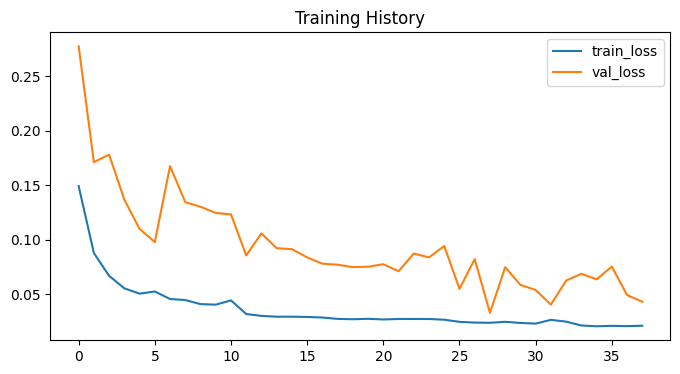

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test MAE: 165.1779, Test RMSE: 271.7372


In [12]:
# Cell 12: Training curves + evaluation (on scaled targets)
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Training History"); plt.show()

# Predict and inverse transform RUL
y_pred_scaled = model.predict(X_test)
y_pred = rul_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = rul_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
try:
    rmse = root_mean_squared_error(y_true, y_pred, squared=False)
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")


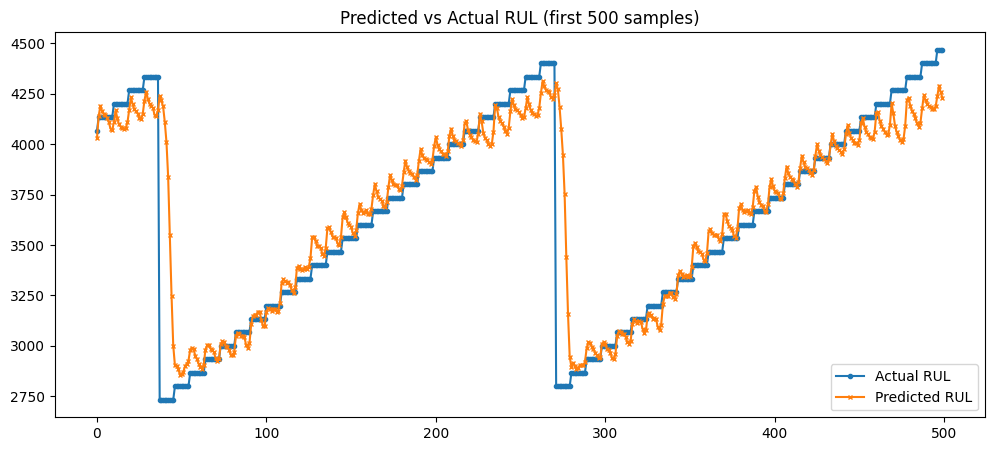

In [14]:
# Cell 13: Plot Predicted vs Actual RUL (first N samples)
N = 500
plt.figure(figsize=(12,5))
plt.plot(y_true[:N], label='Actual RUL', marker='o', markersize=3)
plt.plot(y_pred[:N], label='Predicted RUL', marker='x', markersize=3)
plt.legend(); plt.title("Predicted vs Actual RUL (first {} samples)".format(N)); plt.show()


In [16]:
# Cell 14: Save model and scalers
model.save("rul_lstm_model.keras")
import joblib
joblib.dump(feature_scaler, "feature_scaler.save")
joblib.dump(rul_scaler, "rul_scaler.save")
print("Saved model and scalers.")


Saved model and scalers.
